# Key Points
* Data trained over 6 years and tested over the last 1 year, but due to lax training of the ML model the predicted ratios were not inline with the actual, giving a negative R^2 score
* Training data didn't show stationarity and conintegration among the time series
* The actual prices were picked from the last 1 year historical data and trading was done over that data
* The optimal window length was finalised later

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
import datetime

## Fetching data

In [2]:
tickers = ['ADBE', 'MSFT']
start_train = datetime.datetime(2017,1,1)
end_train = datetime.datetime(2024,1,1)

df_train = yf.download(tickers, start_train, end_train)["Close"]


ADBE = df_train['ADBE']
MSFT = df_train['MSFT']

df_train.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2023-12-22,598.750000,374.579987
2023-12-26,598.260010,374.660004
2023-12-27,596.080017,374.070007
2023-12-28,595.520020,375.279999
2023-12-29,596.599976,376.040009


In [3]:
start_test = datetime.datetime(2024,1,1)
end_test = datetime.datetime(2024,11,30)

df_test = yf.download(tickers, start_test, end_test)["Close"]


ADBE_test = df_test['ADBE']
MSFT_test = df_test['MSFT']

df_test.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2024-11-22,512.150024,417.000000
2024-11-25,518.729980,418.790009
2024-11-26,525.299988,427.989990
2024-11-27,513.679993,422.989990
2024-11-29,515.929993,423.459991


## Feature Engineering

In [4]:
ratio = ADBE / MSFT
test_ratio = ADBE_test/MSFT_test

In [5]:
def gen_features(ratio_):

    mov_av_5d = ratio_.rolling(window = 5, center = False).mean()
    mov_av_20d = ratio_.rolling(window = 20, center = False).mean()
    mov_av_60d = ratio_.rolling(window = 60, center = False).mean()

    roc_2d = (ratio_ - ratio_.shift(2)) / ratio_.shift(2) * 100

    std_dev_5d = ratio_.rolling(window = 5, center = False).std()
    std_dev_20d = ratio_.rolling(window = 20, center = False).std()
    std_dev_60d = ratio_.rolling(window = 60, center = False).std()

    ratio_lag_1d = ratio_.shift(1)
    
    df_x = pd.DataFrame([mov_av_5d, mov_av_20d, mov_av_60d, roc_2d, std_dev_5d, std_dev_20d, std_dev_60d])
    df_x.fillna(0, inplace=True)
    df_x = df_x.T
    df_x.columns = ['mov_av_5d', 'mov_av_20d', 'mov_av_60d', 'roc_2d', 'std_dev_5d', 'std_dev_20d', 'std_dev_60d']
    
    return df_x

train_X = gen_features(ratio)
test_X = gen_features(test_ratio)


## Train ML model

In [6]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

In [7]:
dates = df_train.index
dates

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1760, freq=None)

In [8]:
X = np.arange(len(df_train.index))
ADBE.values

array([103.48000336, 104.13999939, 105.91000366, ..., 596.08001709,
       595.52001953, 596.59997559])

In [9]:
ratio.values

array([1.65356344, 1.6715891 , 1.70000008, ..., 1.59349856, 1.58686853,
       1.58653325])

### Testing data generated by splitting the train dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_X, ratio.values, 
                                   random_state=42,  
                                   test_size=0.2,  
                                   shuffle=False)

In [11]:
X_test

,mov_av_5d,mov_av_20d,mov_av_60d,roc_2d,std_dev_5d,std_dev_20d,std_dev_60d
Date,,,,,,,
2022-08-08,1.518843,1.498171,1.506469,2.069167,0.022903,0.030049,0.053472
2022-08-09,1.522705,1.499702,1.506296,-1.370053,0.018370,0.029877,0.053439
2022-08-10,1.525337,1.501920,1.505686,-2.150955,0.015561,0.029335,0.053108
2022-08-11,1.524769,1.504286,1.505263,0.273884,0.015941,0.028336,0.052926
2022-08-12,1.523708,1.506639,1.505120,0.700614,0.015507,0.028138,0.052855
...,...,...,...,...,...,...,...
2023-12-22,1.608202,1.627120,1.622393,-0.610656,0.007653,0.028516,0.034557
2023-12-26,1.606012,1.625179,1.622092,-0.611261,0.009218,0.029219,0.034702
2023-12-27,1.600734,1.623416,1.621660,-0.310202,0.006415,0.030044,0.034896


In [12]:
regressor = rfr(n_estimators=100, random_state=42)
# regressor = LinearRegression()

regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
predic = regressor.predict(X_test)

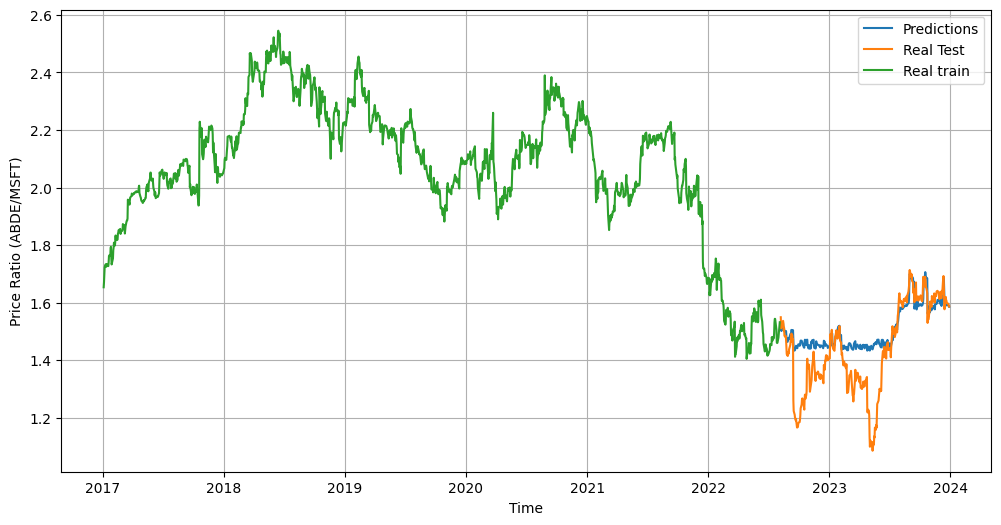

In [14]:
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(X_test.index), predic)
plt.plot(pd.to_datetime(X_test.index), y_test)
plt.plot(pd.to_datetime(X_train.index), y_train)
plt.legend(["Predictions", "Real Test", "Real train"])
plt.xlabel("Time")
plt.ylabel(r"Price Ratio (ABDE/MSFT)")
plt.grid()
plt.show()

### Test data as separate

In [15]:
regressor = rfr(n_estimators=100, random_state=52)
# regressor = LinearRegression()

regressor.fit(df_train, ratio)

RandomForestRegressor(random_state=52)

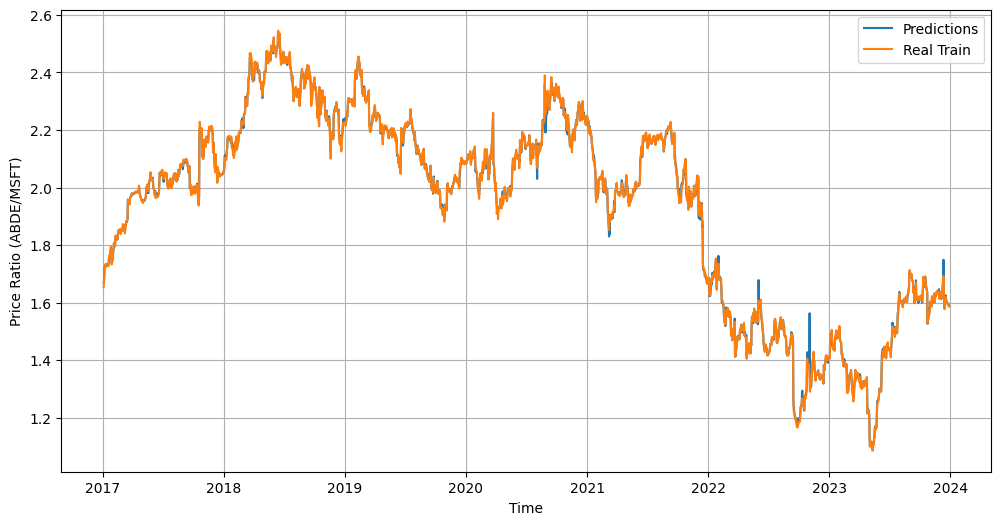

In [16]:
train_pred = regressor.predict(df_train)
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df_train.index), train_pred)
plt.plot(pd.to_datetime(df_train.index), ratio)
plt.legend(["Predictions", "Real Train"])
plt.xlabel("Time")
plt.ylabel(r"Price Ratio (ABDE/MSFT)")
plt.grid()
plt.show()

In [17]:
predic = regressor.predict(df_test)

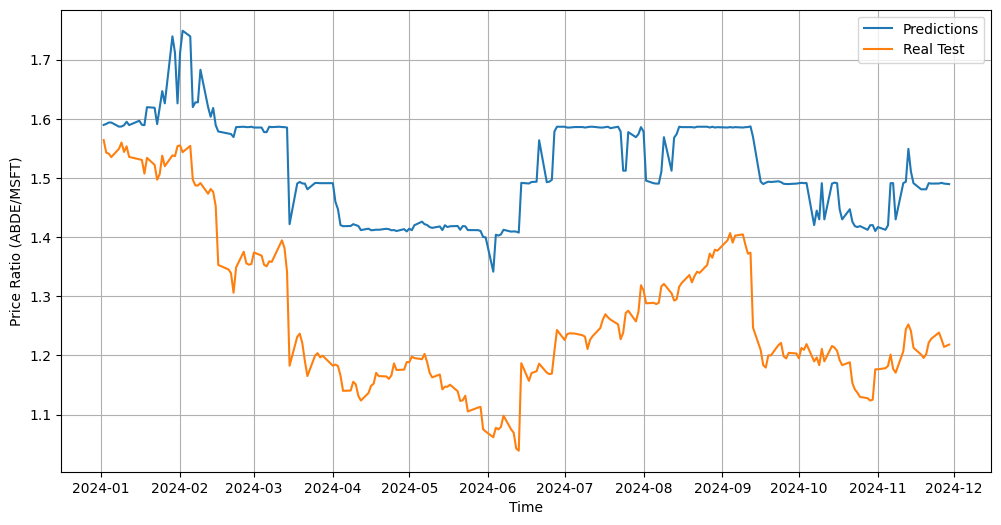

-2.9450459763857815

In [18]:
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df_test.index), predic)
plt.plot(pd.to_datetime(df_test.index), test_ratio)
plt.legend(["Predictions", "Real Test"])
plt.xlabel("Time")
plt.ylabel(r"Price Ratio (ABDE/MSFT)")
plt.grid()
plt.show()

r2_score(test_ratio, predic)

The prediction is pathetic but still moving on to trade with the signals

## Generate Trading Signals

Stationarity validation

In [19]:
from statsmodels.tsa.stattools import coint, adfuller

In [20]:
def stationarity_test(X, cutoff=0.01):
    pvalue = adfuller(X)[1]
    if pvalue>cutoff:
        print(X.name + " is likely non-stationary")
    else:
        print(X.name + " is likely stationary")

stationarity_test(df_train['ADBE'])
stationarity_test(df_train['MSFT'])

ADBE is likely non-stationary
MSFT is likely non-stationary


Cointegration validation

In [21]:
score, pval, _ = coint(df_train['ADBE'], df_train['MSFT'])
pval

0.5488027446927505

High p value => May not be coingrated

In [22]:
df_pred = gen_features(pd.Series(predic))
mov_av_20 = df_pred['mov_av_20d']
std_dev_20 = df_pred['std_dev_20d']

z_score = np.array([ (predic[i] - mov_av_20[i])/std_dev_20[i] for i in range(len(predic))])

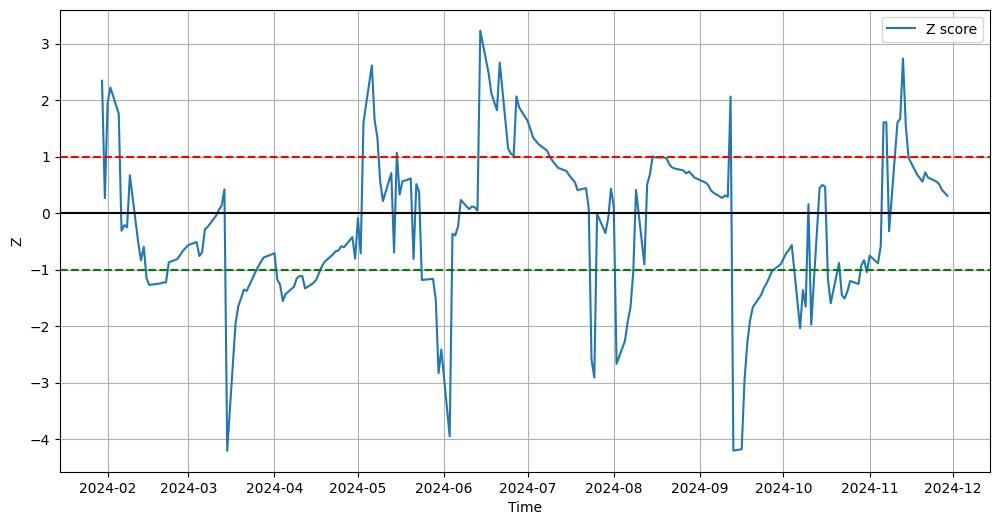

In [23]:
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df_test.index), z_score)
plt.legend(["Z score"])
plt.xlabel("Time")
plt.ylabel(r"Z")
plt.grid()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.show()

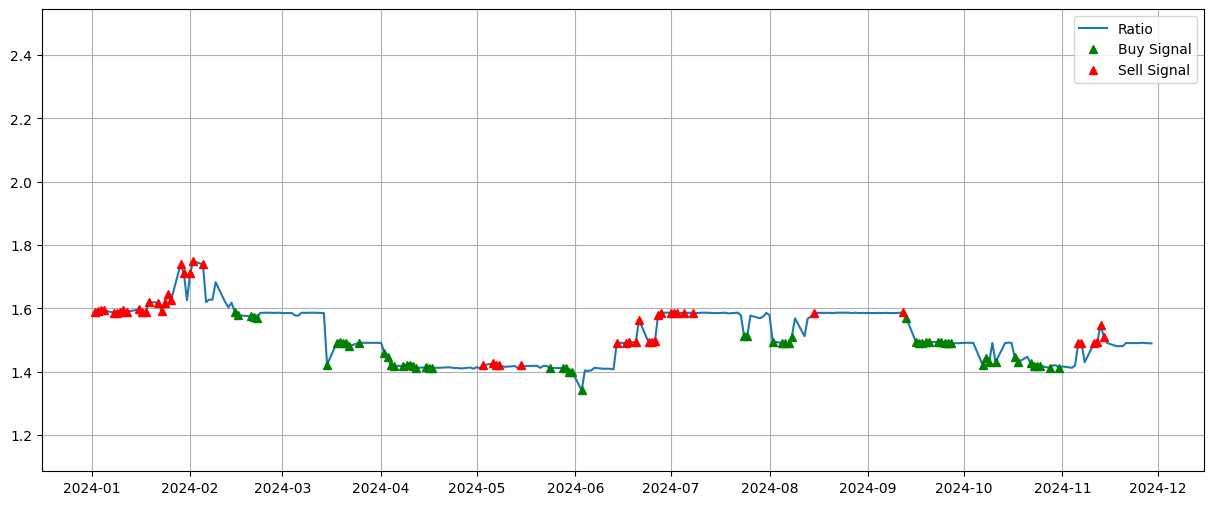

In [24]:
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df_test.index), predic)
buy = predic.copy()
sell = predic.copy()
buy[z_score>-1] = 0
sell[z_score<1] = 0
plt.plot(pd.to_datetime(df_test.index),buy, color='g', linestyle='None', marker='^')
plt.plot(pd.to_datetime(df_test.index),sell, color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.grid()
plt.axis((x1, x2, ratio.min(), ratio.max()))
# plt.xlim(start_test, end_test)
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

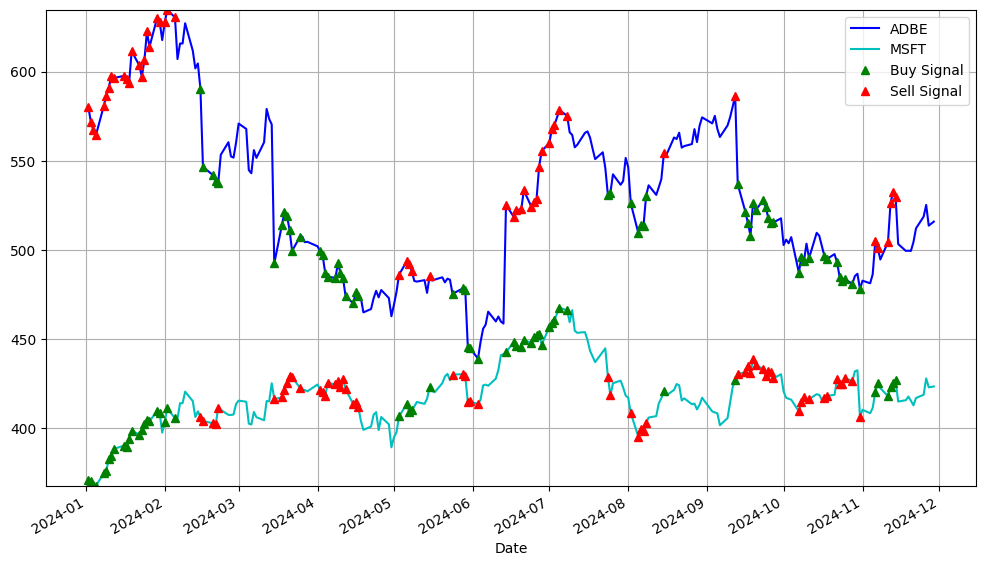

In [25]:
plt.figure(figsize=(12,7))
S1 = df_test['ADBE']
S2 = df_test['MSFT']

S1.plot(color='b')
S2.plot(color='c')
buyR = 0*S1.values.copy()
sellR = 0*S1.values.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1.values[buy!=0]
sellR[buy!=0] = S2.values[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2.values[sell!=0]
sellR[sell!=0] = S1.values[sell!=0]

plt.plot(pd.to_datetime(df_test.index), buyR,color='g', linestyle='None', marker='^')
plt.plot(pd.to_datetime(df_test.index),sellR,color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.grid()
plt.show()

In [26]:
def trade(S1, S2):
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(test_ratio)):
        # Buy long if the z-score is < -1
        if z_score[i] < -1:
            money -= S1[i] - S2[i] * predic[i]
            countS1 += 1
            countS2 -= predic[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Sell short if the z-score is > 1
        elif z_score[i] > 1:
            money += S1[i] - S2[i] * predic[i]
            countS1 -= 1
            countS2 += predic[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(z_score[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))

    return money

In [27]:
trade(S1.values, S2.values)

83.95604588399033

### Finding optimal window length

In [28]:
def trade_custom_window(S1, S2, window1, window2):
    
    ma1 = pd.Series(predic).rolling(window = window1, center = False).mean()
    ma1.fillna(0, inplace=True)
    ma2 = pd.Series(predic).rolling(window = window2, center = False).mean()
    ma2.fillna(0, inplace=True)
    std = pd.Series(predic).rolling(window = window2, center = False).std()
    std.fillna(0, inplace=True)
    z = (ma1-ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(test_ratio)):
        # Buy long if the z-score is < -1
        if z[i] < -1:
            money -= S1[i] - S2[i] * predic[i]
            countS1 += 1
            countS2 -= predic[i]
        # Sell short if the z-score is > 1
        elif z[i] > 1:
            money += S1[i] - S2[i] * predic[i]
            countS1 -= 1
            countS2 += predic[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(z[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print(std)
    return money
    

def searching_optimal_window(S1, S2):
    return [trade_custom_window(S1, S2, l, 20) for l in range(200)]


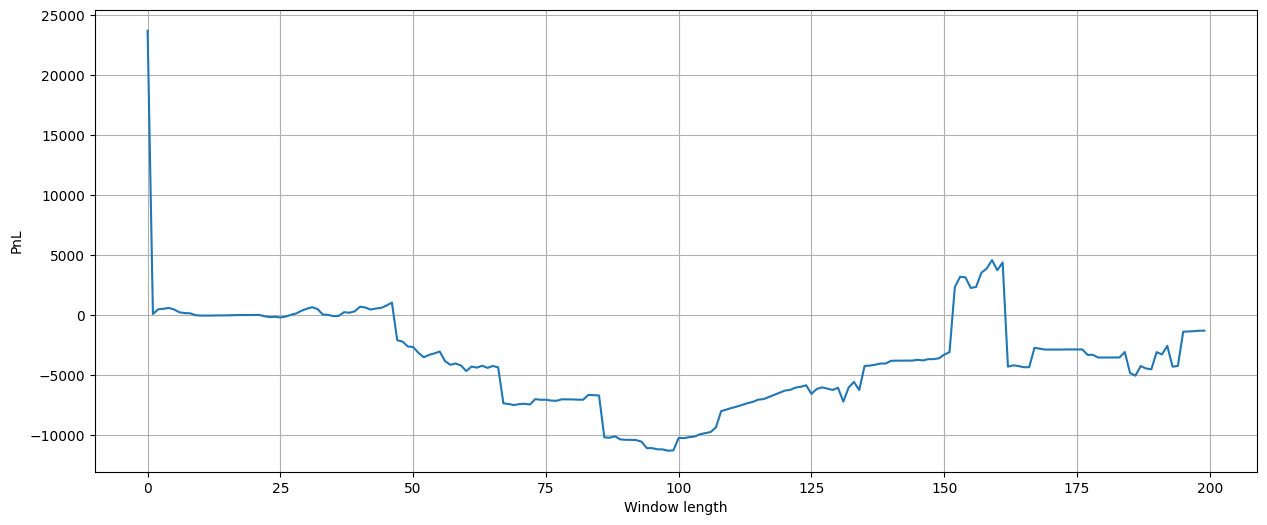

In [29]:
PnLs = searching_optimal_window(df_test['ADBE'].values, df_test['MSFT'].values)

plt.figure(figsize=(15,6))
plt.plot(PnLs)
plt.xlabel('Window length')
plt.ylabel('PnL')
plt.grid()

In [30]:
np.array(PnLs[1:]).argmax()

158

In [31]:
max(PnLs[1:])

4579.471078524989

Maximum Profit generated is 4579